In [1]:
import numpy as np
from celluloid import Camera
import matplotlib.pyplot as plt

class Agent:   # Position and speed
      def __init__(self,position,speed):
            self.position = np.array(position)
            self.speed = speed
            
class Prey(Agent):
    def escape(self,agents): # Escape function for Prey under panic
        target= [a for a in agents if type(a)==Predator]
        vector = target[0].position - self.position # direction vector
        vector = vector / np.sqrt(np.sum(vector**2)) # normalised to make it a unit vector with direction information
        self.position = self.position - (vector) * self.speed # updated position
        
    def flock_normal(self,agents): # when no predation, prey move constantly to a random position. In this case, its (10,8)
        target = [10,8]
        vector = target - self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + vector * self.speed   

    def converge(self,agents): # converge under predation, while escaping the predator
        target1=[0,0]
        target1[0] = np.mean([a.position[0] for a in agents if type(a)==Prey])
        target1[1] = np.mean([a.position[1] for a in agents if type(a)==Prey])
        target2= [a for a in agents if type(a)==Predator]
        
        vector1 = target1 - self.position # target 1 is centroid of all preys
        vector2 = target2[0].position - self.position  # predator
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        
        target3=[10,8] # flock point
        vector3 = target3 - self.position
        vector3 = vector3 / np.sqrt(np.sum(vector3**2))
        a1,a2,a3=1.2,0.7,0.3 # weights for direction vector
        self.position = self.position + (a1*vector1 - a2*vector2 + a3*vector3) * self.speed / (a1 + a2 + a3)
    
    
    def diverge(self,agents): # diverge pattern, while evading the predator
        target1=[0,0]
        target1[0] = np.mean([a.position[0] for a in agents if type(a)==Prey])
        target1[1] = np.mean([a.position[1] for a in agents if type(a)==Prey])
        target2= [a for a in agents if type(a)==Predator]
        
        vector1 = target1 - self.position
        vector2 = target2[0].position - self.position
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        a1,a2=0.5,1.5
        self.position = self.position - (a1*vector1 + a2*vector2) * self.speed / (a1 + a2)
    
    def make_subgroup(self, agents, neighbours): # temporary leaders which help in formation of subgroups
        # neighbours contains list IDs of preys near the temporary leader
        target1=[0,0]
        target1[0] = np.mean([a.position[0] for a in neighbours if type(a)==Prey and a!=self]) 
        target1[1] = np.mean([a.position[1] for a in neighbours if type(a)==Prey and a!=self]) 
        target2= [a for a in agents if type(a)==Predator]
        
        vector1 = target1 - self.position  # centroid of subgroup
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = target2[0].position - self.position
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        self.position = self.position + (vector1-vector2) * self.speed/(4)
                
        
class Predator(Agent):
    def hunt_isolated(self,agents):  # Attack the closest prey under panic
        dist_list=[] # A list to store distance between the predator and each prey
        for a in agents:
            if type(a)==Prey:
                dist_list.append(np.sum((self.position-a.position)**2))
        dist_list=np.asarray(dist_list)
        target = agents[np.argmin(dist_list)+1] # 
        vector= target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed        
    
    def slow_down(self,agents): # After consuming a prey, the predator slows down for awhile
        dist_list=[] 
        for a in agents:
            if type(a)==Prey:
                dist_list.append(np.sum((self.position-a.position)**2))
        dist_list=np.asarray(dist_list)
        target = agents[np.argmin(dist_list)+1] 
        
        vector = target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed/4 # quarter speed
        
    def hunt_group(self,agents): # Attack the nearest group
        target=[0,0]
        dist_list=[] 
        for a in agents:
            if type(a)==Prey:
                dist_list.append(np.sum((self.position-a.position)**2))
        dist_list=np.asarray(dist_list)
        
        nearest = np.argsort(dist_list)[:4] # Pick the 4 nearest preys
        target[0] = np.mean([a.position[0] for a in np.asarray(agents)[nearest+1] if type(a)==Prey]) 
        target[1] = np.mean([a.position[1] for a in np.asarray(agents)[nearest+1] if type(a)==Prey]) 
        vector= target-self.position # direction to center of the 4 preys
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed
        
    def hunt_dense(self,agents): # Attack the most dense group
        dense_prey = list(group_density(agents[1:]).keys()) # A sorted list in decreasing order containing the IDs of prey with most neighbours
        target =agents[dense_prey[0]]
        vector= target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed
        
def nearest_neighbours(preyX): # returns a dictionary with temporary leaders and keys being the followers or neighbours
    # preyX is a matrix containing distances
    temp_dict=dict()
    prey_IDs= list(range((preyX.shape[0])))
    for i in prey_IDs:
        distances=preyX[i,:]
        group_of= 7 # number of neighbours
        nearest = np.argsort(distances)[:group_of]
        nearest = list(nearest)
        del nearest[0]
        for prey_numb in nearest:
            if prey_numb in temp_dict: nearest.remove(prey_numb)
            if prey_numb in prey_IDs: prey_IDs.remove(prey_numb)
        temp_dict[i] = nearest
    return temp_dict

def agent_interaction(agents): # A function which generates matrix containing distances between each agent
    k=len(agents)
    x=np.zeros(shape=(k,k))
    for i in range(k):
        for j in range(k):
            x[i,j]=np.sum((agents[i].position-agents[j].position)**2)
    return x

def group_density(agents): # A function which returns a sorted dictionary containing prey ID as keys and the number of preys close to it
    gdd={}
    X=agent_interaction(agents)
    for i in range(len(agents)):
        p=sum(k < 0.5 for k in X[i,:]) # Distance 0.5 to define close or not
        gdd[i+1]=p
    gdd2= dict(sorted(gdd.items(), key=lambda x: x[1], reverse=True))
    return gdd2

We now simulate 3 different sets of pattern changes:

i.) converge, diverge and subgroup

ii.) diverge, converge and subgroup

iii.) subgroup, diverge and converge

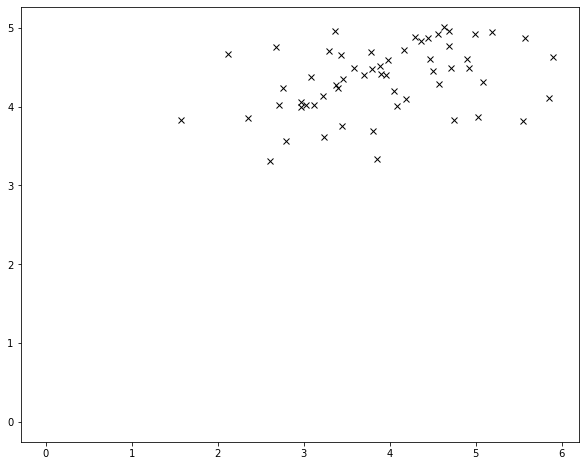

In [6]:
agents=[Predator([0,0],0.07)]# speed of predator=0.07, and starts at (0,0)
np.random.seed(0)
for i in range(60): # 60 preys, with speed 0.055, and start at random location between (0,0) and(3,3)
    agents.append(Prey(np.random.rand(2)*3,0.055))

max_iter=100 #maximun iteration
slow_switch=-3 # To control slowing of predator
fig = plt.figure(figsize=(10,8)) # create a figure
camera = Camera(fig) # for animation
density1=[]  # To compute density
switch_1=False # Boolean to control subgroup and hunt group interaction
for it in range(max_iter):
    X=agent_interaction(agents) # distance matrix between all agents
    risk=np.argmin(X[0,1:]) # The prey closest to predator, and at risk
    if X[0,risk+1]<0.01:   # Eaten if predator close to prey
        del agents[risk+1]
        slow_switch=it   # Store the iteration number where prey was eaten
    agents2=agents.copy() # copy of list to update in various loops and preserve original agents
    
    if X[0,risk+1]<0.5: #panic if predator gets to the panic distance of closest prey
        agents2[risk+1].escape(agents) # The agent at risk just tries to escape
        if it>slow_switch+5: agents2[0].hunt_isolated(agents) # If predator not on rest, and within panic distance
        del agents2[risk+1] # remove panic prey from 2nd list to use for other loops
        
    else: #If no panic
        if it<slow_switch+5: # For 5 iteration after eating a prey
            agents2[0].slow_down(agents) # Predator slow down
        else: # If no panic and no slow down, default hunt method, unless different attack mode
            if switch_1==False: agents2[0].hunt_group(agents)
    switch_1=False # Keep switch active
    
    if it<11: # Normal flock behaviour for first few iterations
        for a in agents2[1:]: 
            a.flock_normal(agents2)
    if it>10 and it<51:  # Converge pattern for few iterations
        for a in agents2[1:]: 
            a.converge(agents2)
    if it>50 and it<76: # Diverge pattern for few iterations
        for a in agents2[1:]: 
            a.diverge(agents)
    if it>75: # Sub groups pattern 
        switch_1=True # boolean for different predator attack pattern
        agents2[0].hunt_dense(agents)
        neighbours= nearest_neighbours(X[1:,1:]) # A dictionary 
        for i in list(neighbours.keys()):
            indices= neighbours[i] # The ID's of preys neighbour to the subgroup leaders
            agents[i+1].make_subgroup(agents,np.asarray(agents)[indices]) # Sub group leaders make the sub group
            for j in indices: 
                if j!=0: agents[j].flock_normal(agents) # The neighbours flock normally
    density1.append(np.mean(list(group_density(agents[1:]).values()))) # density of preys for each iter
    for a in agents: # Plotting simulation
        if type(a)==Predator:
            plt.plot(a.position[0],a.position[1],'or')
            camera.snap() # snap the plot to convert into animation
        if type(a)==Prey:
            plt.plot(a.position[0],a.position[1],'xk')
    
camera.snap()    
sim1=len(agents[1:])

animation = camera.animate()
#animation.save('sim.gif')
from IPython.display import HTML
HTML(animation.to_jshtml())

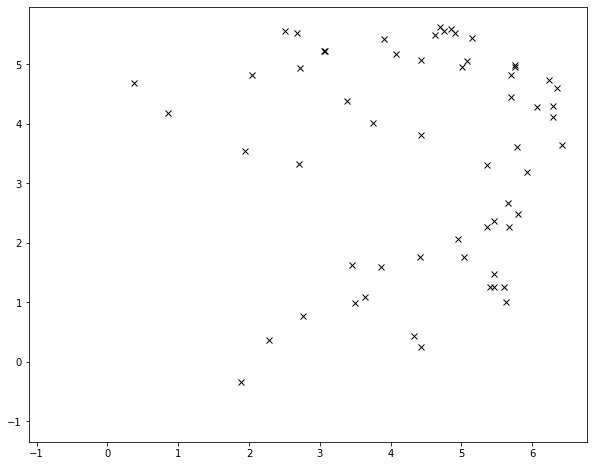

In [7]:
# Simulate different pattern for different period of time to check the survival rate and density
agents=[Predator([0,0],0.07)] 
np.random.seed(0)
for i in range(60): 
    agents.append(Prey(np.random.rand(2)*3,0.055))
density2=[]
max_iter=100
slow_switch=-3
fig = plt.figure(figsize=(10,8))
camera = Camera(fig)
switch_1=False
for it in range(max_iter):
    X=agent_interaction(agents)
    risk=np.argmin(X[0,1:])
    if X[0,risk+1]<0.01:   # Eaten
        del agents[risk+1]
        slow_switch=it
    agents2=agents.copy()
    if X[0,risk+1]<0.5: #panic
        agents2[risk+1].escape(agents)
        if it>slow_switch+5: agents2[0].hunt_isolated(agents)
        del agents2[risk+1]
    else:
        if it<slow_switch+5:
            agents2[0].slow_down(agents)
        else:
            if switch_1==False: agents2[0].hunt_group(agents)
    switch_1=False
    if it<11:
        for a in agents2[1:]: 
            a.flock_normal(agents2)
    if it>50 and it<76:
        for a in agents2[1:]: 
            a.converge(agents2)
    if it>10 and it<51:
        for a in agents2[1:]: 
            a.diverge(agents)
    if it>75 and it<100:
        switch_1=True
        agents2[0].hunt_dense(agents)
        neighbours= nearest_neighbours(X[1:,1:])
        index=0
        for i in list(neighbours.keys()):
            indices= neighbours[i]
            agents[i+1].make_subgroup(agents,np.asarray(agents)[indices])
            for j in indices: agents[j+1].flock_normal(agents)
    density2.append(np.mean(list(group_density(agents[1:]).values())))
    for a in agents:
        if type(a)==Predator:
            plt.plot(a.position[0],a.position[1],'or')
            camera.snap()
        if type(a)==Prey:
            plt.plot(a.position[0],a.position[1],'xk')
camera.snap()    
sim2=len(agents[1:])
animation = camera.animate()
#animation.save('sim.gif')
from IPython.display import HTML
HTML(animation.to_jshtml())

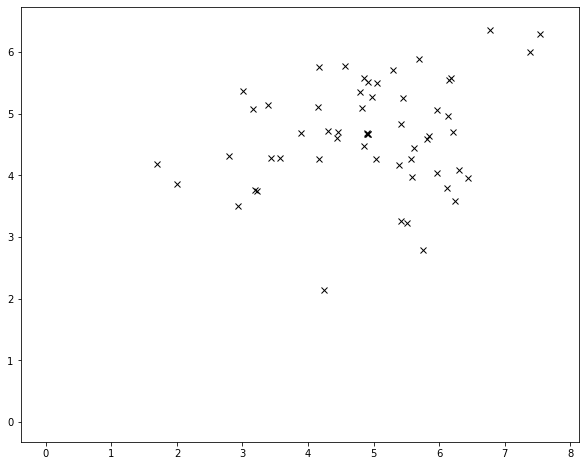

In [8]:
agents=[Predator([0,0],0.07)]
np.random.seed(0)
for i in range(60):
    agents.append(Prey(np.random.rand(2)*3,0.055))
density3=[]
max_iter=100
slow_switch=-3
fig = plt.figure(figsize=(10,8))
camera = Camera(fig)
switch_1=False
for it in range(max_iter):
    hunt=False
    X=agent_interaction(agents)
    risk=np.argmin(X[0,1:])
    if X[0,risk+1]<0.01:   # Eaten
        del agents[risk+1]
        slow_switch=it
    agents2=agents.copy()
    if X[0,risk+1]<0.5: #panic
        agents2[risk+1].escape(agents)
        hunt=True
        if it>slow_switch+5: agents2[0].hunt_isolated(agents)
        del agents2[risk+1]
    else:
        if it<slow_switch+5:
            agents2[0].slow_down(agents)
        else:
            if switch_1==False: agents2[0].hunt_group(agents)
    #agents2[1].leader_move(agents)
    switch_1=False
    if it<11:
        for a in agents2[1:]: 
            a.flock_normal(agents2)
    if it>75 and it<100:
        for a in agents2[1:]: 
            a.converge(agents2)
    if it>50 and it<76:
        for a in agents2[1:]: 
            a.diverge(agents)
    if it>10 and it<51:
        switch_1=True
        if hunt==False: agents2[0].hunt_dense(agents)
        neighbours= nearest_neighbours(X[1:,1:])
        index=0
        for i in list(neighbours.keys()):
            indices= neighbours[i]
            agents[i+1].make_subgroup(agents,np.asarray(agents)[indices])
            for j in indices: 
                if j!=0: agents[j].flock_normal(agents)
    density3.append(np.mean(list(group_density(agents[1:]).values())))
    for a in agents:
        if type(a)==Predator:
            plt.plot(a.position[0],a.position[1],'or')
            camera.snap()
        if type(a)==Prey:
            plt.plot(a.position[0],a.position[1],'xk')
camera.snap()    
sim3=len(agents[1:])
animation = camera.animate()
#animation.save('sim.gif')
from IPython.display import HTML
HTML(animation.to_jshtml())

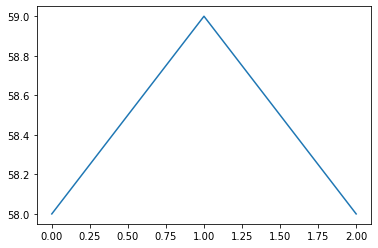

In [9]:
sims=[sim1,sim2,sim3]
plt.plot(sims)

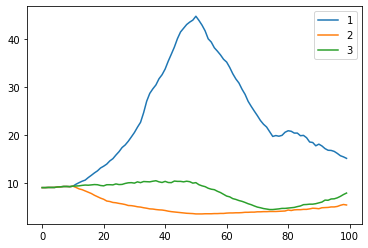

In [10]:
plt.plot(density1,label='1')
plt.plot(density2,label='2')
plt.plot(density3,label='3')
plt.legend();